## Isolation forest

### Importing Libraries

In [127]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pandas as pd
from adtk.detector import SeasonalAD
from adtk.data import validate_series


### Loading the dataset

In [138]:
df = pd.read_csv('../SavedData/dataset2_cleaned.csv')
df_copy= df.copy()
df['Datetime'] = pd.to_datetime(df['Datetime'])
df_copy['Datetime'] = pd.to_datetime(df_copy['Datetime'])
df.set_index('Datetime', inplace=True)

# Assuming we're focusing on total 'Amount' over time, for simplicity
#df_daily = df.resample('D').sum()['Amount']

### Splitting the dataset into training and testing

In [129]:

training_transactions, testing_transactions = train_test_split(df, test_size=0.2, random_state=2)

# Displaying the shapes to verify the split
training_transactions.shape, testing_transactions.shape

training_payments_df = training_transactions[training_transactions['Amount'] > 0]
training_expenditures_df = training_transactions[training_transactions['Amount'] < 0]
training_expenditures_df["Amount"] = training_expenditures_df["Amount"].abs()

testing_payments_df = testing_transactions[testing_transactions['Amount'] > 0]
testing_expenditures_df = testing_transactions[testing_transactions['Amount'] < 0]
testing_expenditures_df["Amount"] = testing_expenditures_df["Amount"].abs()


/var/folders/rw/215myrns4md_n1k8nkyww6mw0000gn/T/ipykernel_77671/730436024.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training_expenditures_df["Amount"] = training_expenditures_df["Amount"].abs()
/var/folders/rw/215myrns4md_n1k8nkyww6mw0000gn/T/ipykernel_77671/730436024.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testing_expenditures_df["Amount"] = testing_expenditures_df["Amount"].abs()


## Creating an anomaly detection model based on TimeStamps 

In [130]:
training_expenditures_df['Hour'] = training_expenditures_df['Datetime'].dt.hour

# Group by 'Account No' and 'Hour', then count the frequency of each 'Hour' for an account
hourly_interactions = training_expenditures_df.groupby(['Account No', 'Hour']).size().reset_index(name='Frequency')

# Find the hours with the least frequency for each account
least_frequent_hours = hourly_interactions.sort_values(['Account No', 'Frequency', 'Hour']).drop_duplicates('Account No', keep='first')

def find_hours_in_lowest_quintile(group):
    # Determine the 20th percentile (lowest quintile) of frequency for the group
    threshold = group['Frequency'].quantile(0.1)
    # Return all hours where the frequency is less than or equal to this threshold
    return group[group['Frequency'] <= threshold]['Hour'].tolist()

# Group by 'Account No' to calculate and gather hours in the lowest quintile for each account
accounts_least_frqt_hour = hourly_interactions.groupby('Account No').apply(find_hours_in_lowest_quintile).reset_index(name='Hours in Lowest 20% Quintile')
accounts_least_frqt_hour.set_index('Account No', inplace=True)
accounts_hours_dict = accounts_least_frqt_hour['Hours in Lowest 20% Quintile'].to_dict()

/var/folders/rw/215myrns4md_n1k8nkyww6mw0000gn/T/ipykernel_77671/3478778189.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training_expenditures_df['Hour'] = training_expenditures_df['Datetime'].dt.hour


In [131]:
testing_expenditures_df['Hour'] = testing_expenditures_df['Datetime'].dt.hour

def check_anomaly(row):
    account_no = row['Account No']
    hour = row['Hour']
    least_frqt_hours = accounts_hours_dict.get(account_no, [])
    return hour in least_frqt_hours

# Apply the function to each row in the testing dataframe
testing_expenditures_df['Anomaly'] = testing_expenditures_df.apply(check_anomaly, axis=1)

# Filter the testing_expenditures_df to only include rows where 'Anomaly' is True
anomalies_df = testing_expenditures_df[testing_expenditures_df['Anomaly'] == True]

anomalies_df



/var/folders/rw/215myrns4md_n1k8nkyww6mw0000gn/T/ipykernel_77671/4139403026.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testing_expenditures_df['Hour'] = testing_expenditures_df['Datetime'].dt.hour
/var/folders/rw/215myrns4md_n1k8nkyww6mw0000gn/T/ipykernel_77671/4139403026.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testing_expenditures_df['Anomaly'] = testing_expenditures_df.apply(check_anomaly, axis=1)


,Date,Timestamp,Account No,Balance,Amount,Third Party Account No,Third Party Name,Datetime,Hour,Anomaly
3133,01/01/2023,00:00:00,279149837.0,1532.010000,100.00,NaN,Grand Union BJJ,2023-01-01 00:00:00,0,True
169619,19/09/2023,06:52:00,662610817.0,-1178.855681,32.09,NaN,Deliveroo,2023-09-19 06:52:00,6,True
28207,04/02/2023,11:11:00,815385232.0,1645.980100,40.95,NaN,Blackwell's,2023-02-04 11:11:00,11,True
184103,05/10/2023,19:40:00,198051483.0,-1231.206910,48.86,NaN,Tesco,2023-10-05 19:40:00,19,True
18706,27/01/2023,19:27:00,985188462.0,987.120914,0.92,NaN,Sainsbury Local,2023-01-27 19:27:00,19,True
...,...,...,...,...,...,...,...,...,...,...
129891,25/07/2023,06:05:00,235310449.0,1255.003305,8.36,NaN,Sainsbury Local,2023-07-25 06:05:00,6,True
28827,05/02/2023,13:07:00,140893085.0,730.446356,224.04,NaN,Tesco,2023-02-05 13:07:00,13,True
142051,07/08/2023,02:07:00,815385232.0,8250.566744,42.17,NaN,Amazon,2023-08-07 02:07:00,2,True
225345,01/12/2023,02:41:00,108931112.0,16892.263207,34.63,NaN,Deliveroo,2023-12-01 02:41:00,2,True


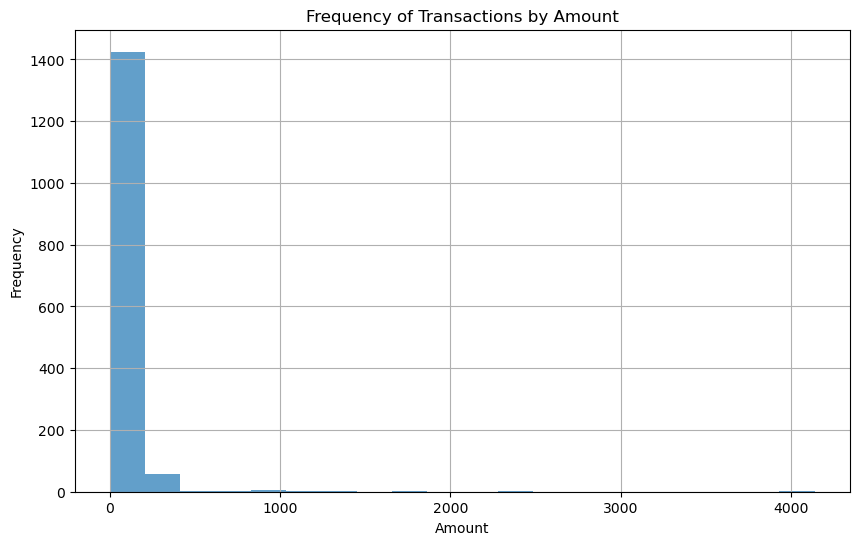

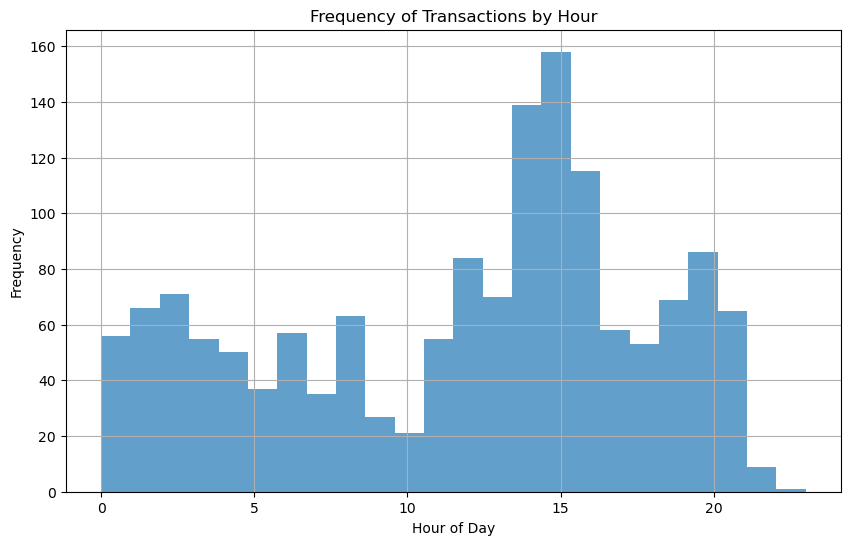

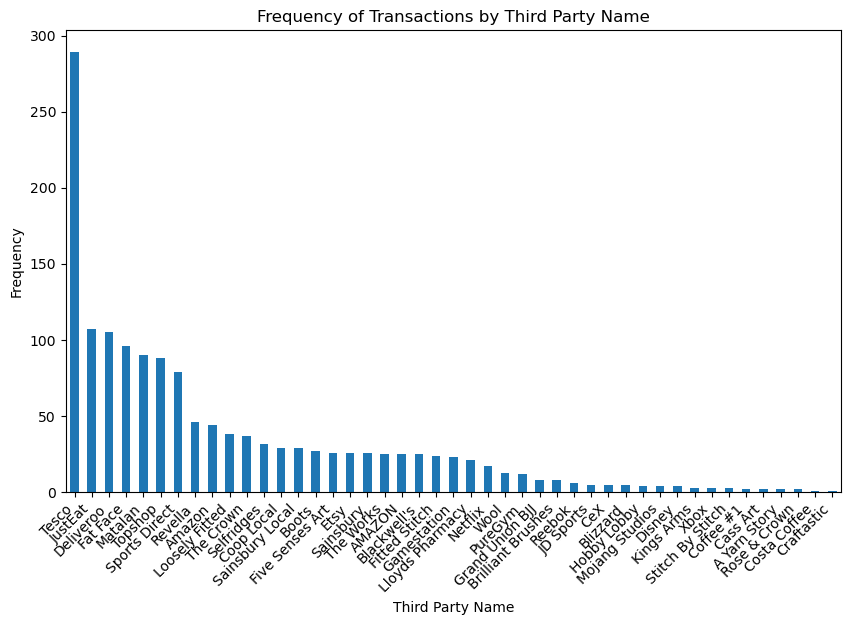

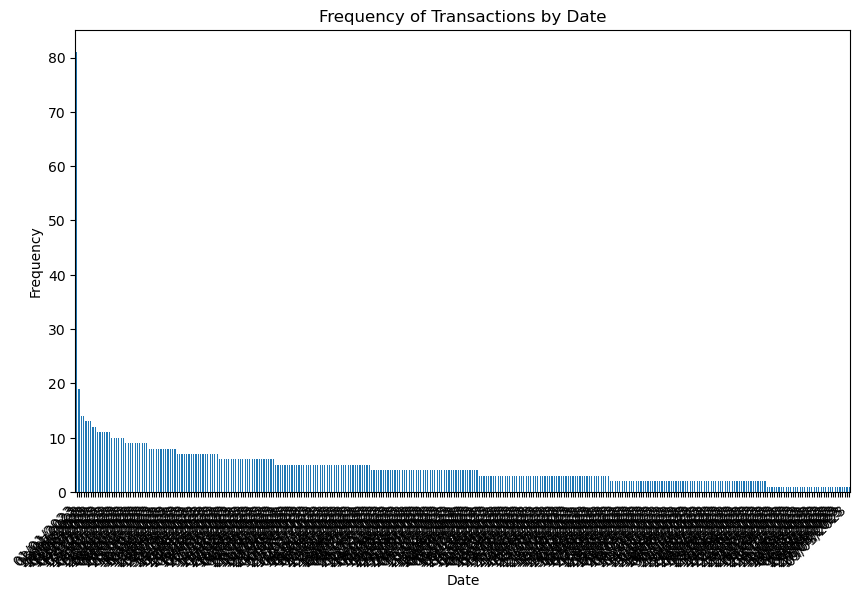

In [146]:
# Amount Frequencies
plt.figure(figsize=(10, 6))
anomalies_df['Amount'].plot(kind='hist', bins=20, alpha=0.7)
plt.title('Frequency of Transactions by Amount')
plt.xlabel('Amount')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Frequency of Transactions by Hour
plt.figure(figsize=(10, 6))
anomalies_df['Hour'].plot(kind='hist', bins=24, alpha=0.7, range=(0, 23))
plt.title('Frequency of Transactions by Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Frequency of Transactions by Third Party Name
plt.figure(figsize=(10, 6))
anomalies_df['Third Party Name'].value_counts().plot(kind='bar')
plt.title('Frequency of Transactions by Third Party Name')
plt.xlabel('Third Party Name')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha="right")
plt.show()

# Frequency of Transactions by Date
plt.figure(figsize=(10, 6))
anomalies_df['Date'].value_counts().plot(kind='bar')
plt.title('Frequency of Transactions by Date')
plt.xlabel('Date')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha="right")
plt.show()

## Isolation Forest Model

In [132]:

training_expenditures_df['DayOfWeek'] = training_expenditures_df['Datetime'].dt.dayofweek
training_expenditures_df['DayOfMonth'] = training_expenditures_df['Datetime'].dt.day
training_expenditures_df['MonthOfYear'] = training_expenditures_df['Datetime'].dt.month


testing_expenditures_df['DayOfWeek'] = testing_expenditures_df['Datetime'].dt.dayofweek
testing_expenditures_df['DayOfMonth'] = testing_expenditures_df['Datetime'].dt.day
testing_expenditures_df['MonthOfYear'] = testing_expenditures_df['Datetime'].dt.month

/var/folders/rw/215myrns4md_n1k8nkyww6mw0000gn/T/ipykernel_77671/3066930005.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training_expenditures_df['DayOfWeek'] = training_expenditures_df['Datetime'].dt.dayofweek
/var/folders/rw/215myrns4md_n1k8nkyww6mw0000gn/T/ipykernel_77671/3066930005.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training_expenditures_df['DayOfMonth'] = training_expenditures_df['Datetime'].dt.day
/var/folders/rw/215myrns4md_n1k8nkyww6mw0000gn/T/ipykernel_77671/3066930005.py:3:

In [133]:
patterns_train = training_expenditures_df.groupby(['Account No', 'Hour', 'DayOfWeek', 'DayOfMonth', 'MonthOfYear', 'Datetime'])['Amount'].sum().reset_index()
patterns_test = testing_expenditures_df.groupby(['Account No', 'Hour', 'DayOfWeek', 'DayOfMonth', 'MonthOfYear', 'Datetime'])['Amount'].sum().reset_index()

In [134]:
patterns_train

,Account No,Hour,DayOfWeek,DayOfMonth,MonthOfYear,Datetime,Amount
0,101531259.0,0,0,1,5,2023-05-01 00:00:00,859.00
1,101531259.0,0,1,1,8,2023-08-01 00:00:00,859.00
2,101531259.0,0,2,1,3,2023-03-01 00:00:00,859.00
3,101531259.0,0,2,1,11,2023-11-01 00:00:00,859.00
4,101531259.0,0,3,1,6,2023-06-01 00:00:00,859.00
...,...,...,...,...,...,...,...
149827,999752672.0,23,4,30,6,2023-06-30 23:59:00,15.99
149828,999752672.0,23,4,31,3,2023-03-31 23:59:00,15.99
149829,999752672.0,23,5,29,4,2023-04-29 23:59:00,680.00
149830,999752672.0,23,5,30,9,2023-09-30 23:59:00,15.99


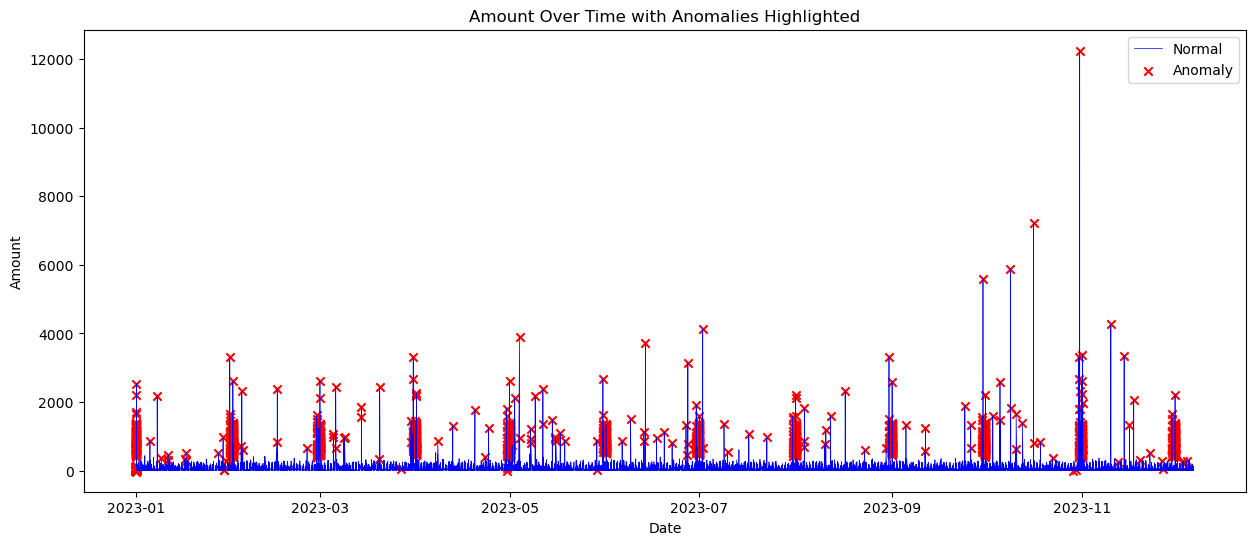

In [135]:
import matplotlib.pyplot as plt

# Assuming patterns_train and patterns_test are your training and test dataframes
# and 'Datetime' column exists in your patterns_test dataframe with actual datetime values.

# Normalize/Standardize features
X_train = patterns_train[['Hour', 'DayOfWeek', 'DayOfMonth', 'MonthOfYear', 'Amount']]
X_test = patterns_test[['Hour', 'DayOfWeek', 'DayOfMonth', 'MonthOfYear', 'Amount']]
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train the Isolation Forest model
model = IsolationForest(n_estimators=100, contamination=0.05)
model.fit(X_train_scaled)

# Predict anomalies
test_preds = model.predict(X_test_scaled)
patterns_test['anomaly'] = test_preds

# Merge the predictions with the original test DataFrame
test_data_with_preds = patterns_test.copy()
test_data_with_preds['Date'] = pd.to_datetime(test_data_with_preds['Datetime'])

# Sort by date for plotting
test_data_with_preds.sort_values('Date', inplace=True)

# Plot
plt.figure(figsize=(15, 6))
plt.plot(test_data_with_preds['Date'], test_data_with_preds['Amount'], label='Normal', color='blue', linestyle='-', linewidth=0.5)
plt.scatter(test_data_with_preds.loc[test_data_with_preds['anomaly'] == -1, 'Date'],
            test_data_with_preds.loc[test_data_with_preds['anomaly'] == -1, 'Amount'],
            color='red', label='Anomaly', marker='x')
plt.xlabel('Date')
plt.ylabel('Amount')
plt.title('Amount Over Time with Anomalies Highlighted')
plt.legend()
plt.show()


## Some EDA for frequency of transactions

In [142]:
df_copy.set_index('Datetime', inplace=True)
payments_df = df_copy[df_copy['Amount'] > 0]
expenditures_df = df_copy[df_copy['Amount'] < 0]
expenditures_df["Amount"] = expenditures_df["Amount"].abs()

/var/folders/rw/215myrns4md_n1k8nkyww6mw0000gn/T/ipykernel_77671/2036389683.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  expenditures_df["Amount"] = expenditures_df["Amount"].abs()


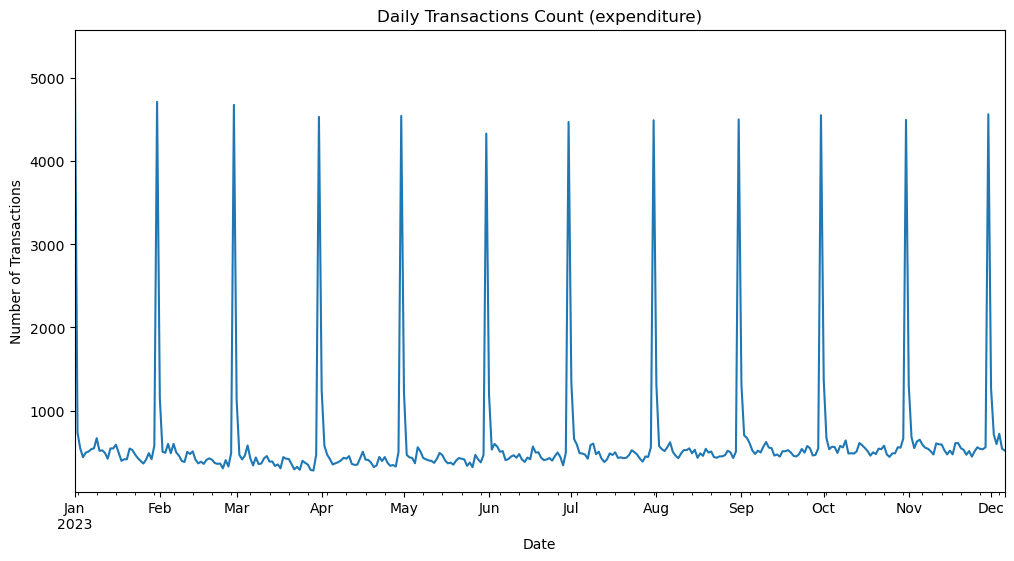

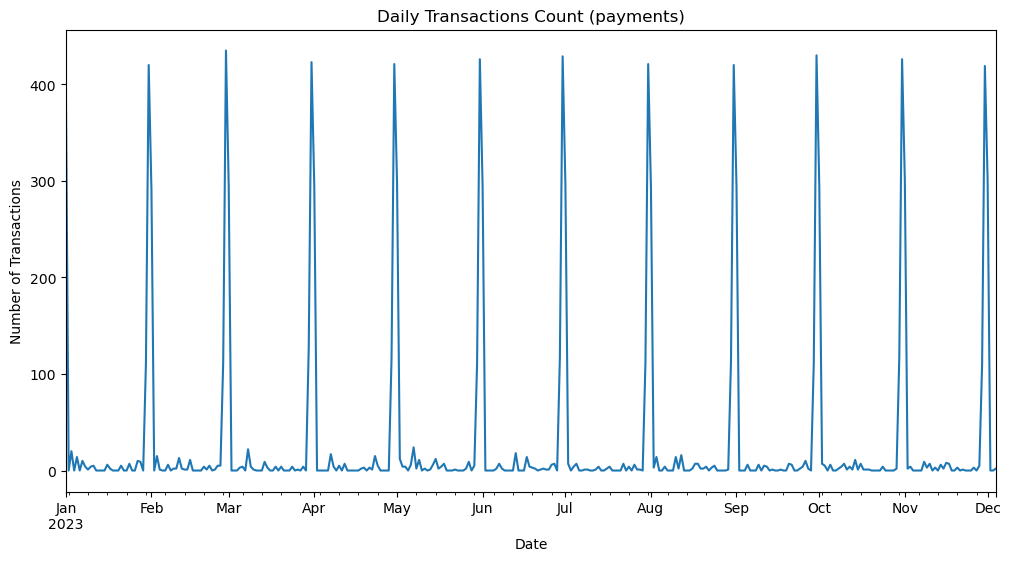

In [143]:
# Sum of all daily transactions
daily_transactions = expenditures_df.resample('D').size()

# Plot
plt.figure(figsize=(12, 6))
daily_transactions.plot(title='Daily Transactions Count (expenditure)')
plt.ylabel('Number of Transactions')
plt.xlabel('Date')
plt.show()

# Sum of all daily transactions
daily_transactions = payments_df.resample('D').size()

# Plot
plt.figure(figsize=(12, 6))
daily_transactions.plot(title='Daily Transactions Count (payments)')
plt.ylabel('Number of Transactions')
plt.xlabel('Date')
plt.show()

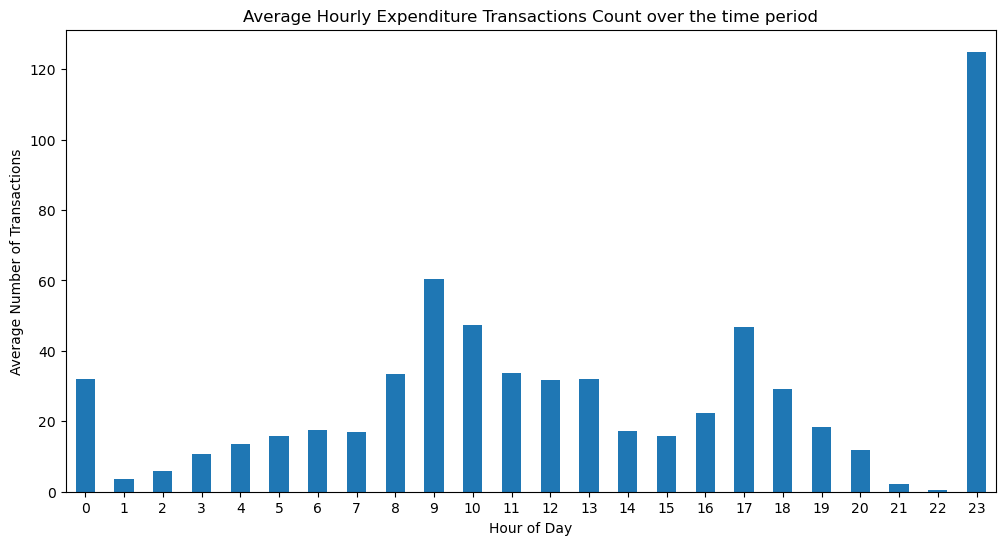

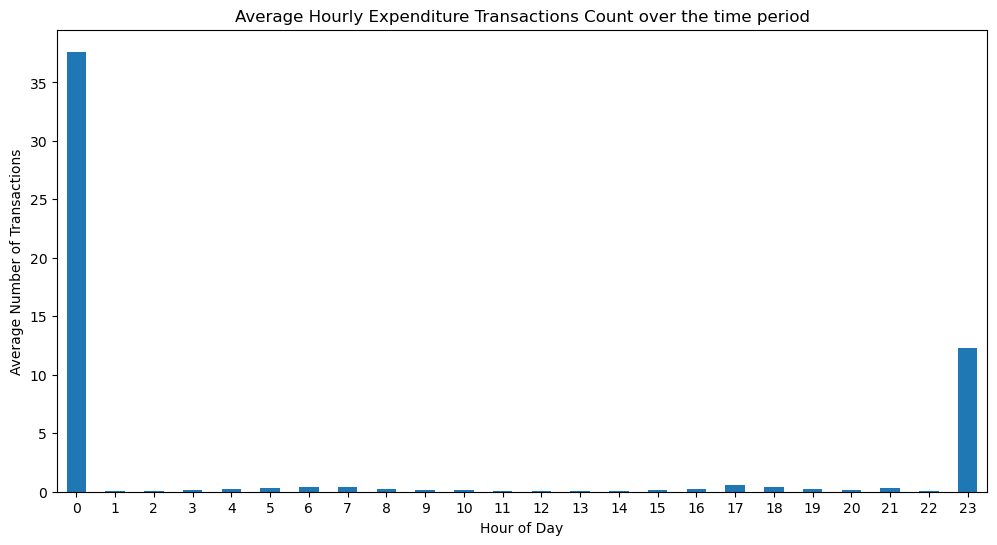

In [144]:
# Calculate the number of unique dates (days) in the DataFrame
unique_days = pd.Series(expenditures_df.index.date).nunique()

# Group by hour and count transactions, then divide by the number of unique days
hourly_transactions = expenditures_df.groupby(expenditures_df.index.hour).size() / unique_days

# Plot
plt.figure(figsize=(12, 6))
hourly_transactions.plot(kind='bar', title='Average Hourly Expenditure Transactions Count over the time period')
plt.ylabel('Average Number of Transactions')
plt.xlabel('Hour of Day')
plt.xticks(rotation=0)
plt.show()

# Calculate the number of unique dates (days) in the DataFrame
unique_days = pd.Series(payments_df.index.date).nunique()

# Group by hour and count transactions, then divide by the number of unique days
hourly_transactions = payments_df.groupby(payments_df.index.hour).size() / unique_days

# Plot
plt.figure(figsize=(12, 6))
hourly_transactions.plot(kind='bar', title='Average Hourly Expenditure Transactions Count over the time period')
plt.ylabel('Average Number of Transactions')
plt.xlabel('Hour of Day')
plt.xticks(rotation=0)
plt.show()



/var/folders/rw/215myrns4md_n1k8nkyww6mw0000gn/T/ipykernel_77671/2188435756.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  weekly_amount_spent = expenditures_df.resample('W').sum()['Amount']


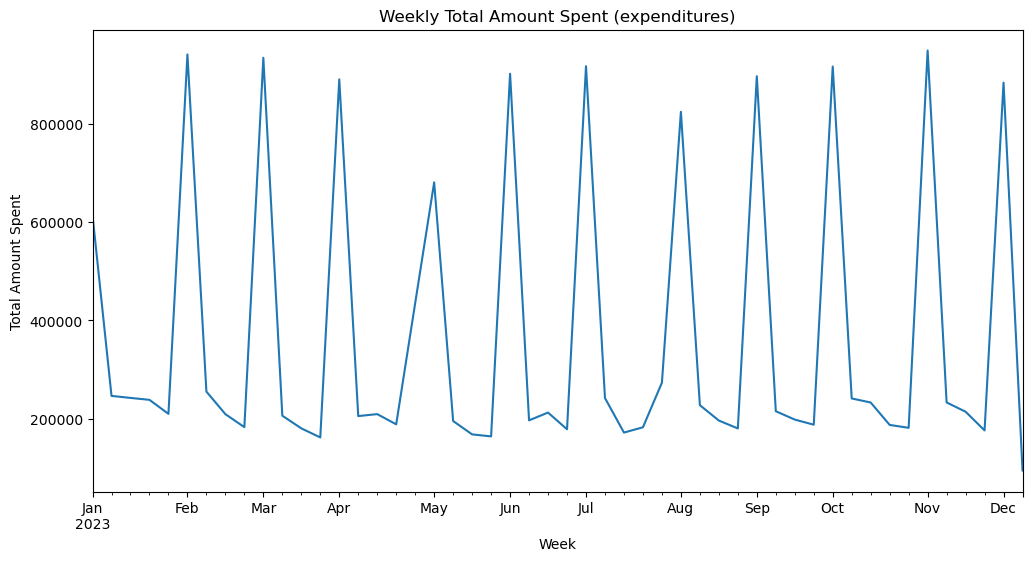

/var/folders/rw/215myrns4md_n1k8nkyww6mw0000gn/T/ipykernel_77671/2188435756.py:12: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  weekly_amount_spent = payments_df.resample('W').sum()['Amount']


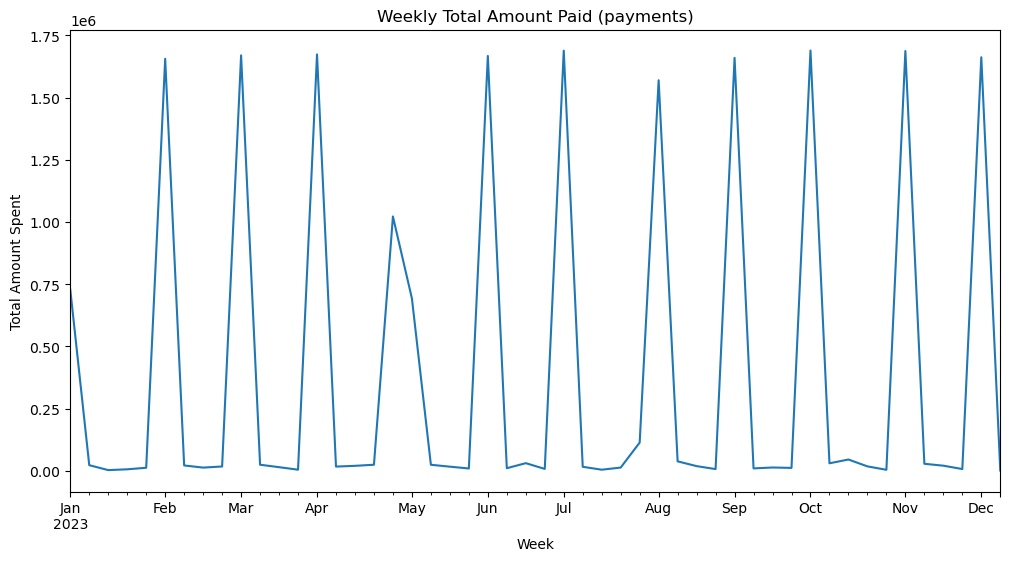

In [145]:
# Sum of amount spent each week
weekly_amount_spent = expenditures_df.resample('W').sum()['Amount']

# Plot
plt.figure(figsize=(12, 6))
weekly_amount_spent.plot(title='Weekly Total Amount Spent (expenditures)')
plt.ylabel('Total Amount Spent')
plt.xlabel('Week')
plt.show()

# Sum of amount spent each week
weekly_amount_spent = payments_df.resample('W').sum()['Amount']

# Plot
plt.figure(figsize=(12, 6))
weekly_amount_spent.plot(title='Weekly Total Amount Paid (payments)')
plt.ylabel('Total Amount Spent')
plt.xlabel('Week')
plt.show()
